# Tutorial for STPSF: Computing Simulated Point Spread Functions for JWST and Roman

This tutorial will walk you through the basics of using the STPSF package to calculate PSFs for JWST and/or the Roman Space Telescope.  Let's begin.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [28]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize'] = (5,4)

## Getting Started

We assume you have already installed stpsf from PyPI, conda,  or some other source, and can successfully import it. 

In [29]:
import stpsf

## First PSFs, and understanding PSF output products

Let's get started with some calculations. STPSF provides a set of classes corresponding to JWST's four science instruments plus its FGS, and to the Roman instruments as well. To calculate a PSF, we first instantiate one of these: 

In [46]:
nc = stpsf.NIRCam()

In the case of NIRCam, which has multiple detectors, the default is set to `NRCA1` for now.  The default filter is F200W. 

And then call its ``calc_psf`` function.  

In [31]:
psf = nc.calc_psf(nlambda=5, fov_arcsec=2)

The returned result is a FITS HDUList object containing both the image data and its associated metadata in the header. 

We can display the PSF that we have just created:

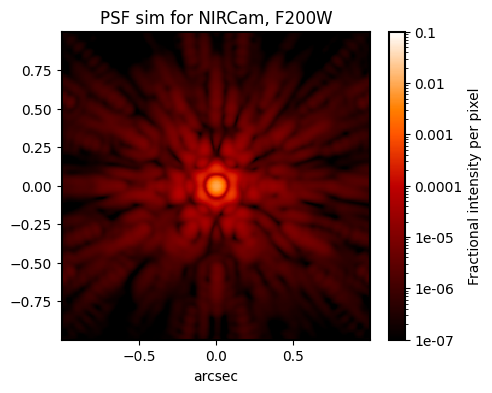

In [32]:
stpsf.display_psf(psf)

The default behavior of STPSF is to compute *oversampled* PSFs (i.e. sampled more finely than the detector pixel scale) by a factor of 4. However, it also produces a version of the same PSF that has been downsampled onto the detector scale. This is saved as an image extension in the same result file. 

Since the PSFs are returned in regular FITS HDUList objects, we can examine, save, and generally manipulate them like any other HDUList. Let's look at the different extensions: 

In [33]:
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     108   (256, 256)   float64   
  1  DET_SAMP      1 ImageHDU       110   (64, 64)   float64   
  2  OVERDIST      1 ImageHDU       162   (256, 256)   float64   
  3  DET_DIST      1 ImageHDU       163   (64, 64)   float64   


The display functions in stpsf allow you to specify an extension, either by index number or by extension name. Let's display the detector-sampled PSF from extension 1.

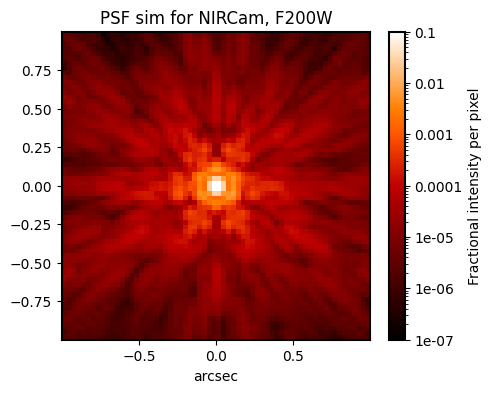

In [34]:
stpsf.display_psf(psf,ext='DET_SAMP')

Let's compare the contents of all 4 FITS images in that PSF output:

Extension 0 has oversampling factor =  4 	Pixelscale = 0.0078 arcsec/pix 	FWHM = 0.0637 arcsec
Extension 1 has oversampling factor =  1 	Pixelscale = 0.0312 arcsec/pix 	FWHM = 0.0656 arcsec
Extension 2 has oversampling factor =  4 	Pixelscale = 0.0078 arcsec/pix 	FWHM = 0.0653 arcsec
Extension 3 has oversampling factor =  1 	Pixelscale = 0.0312 arcsec/pix 	FWHM = 0.0674 arcsec


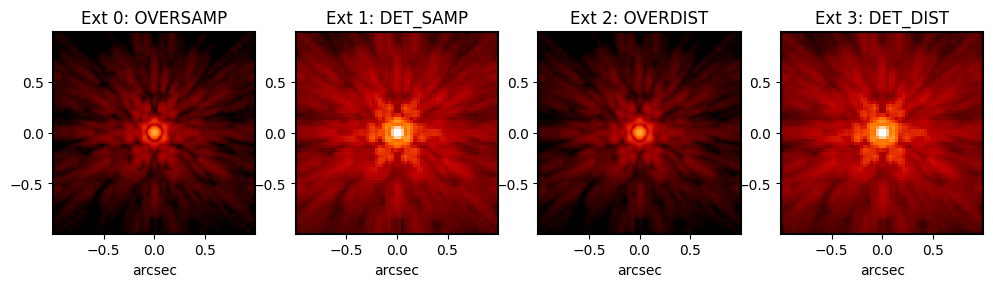

In [35]:
fig, axes = plt.subplots(figsize=(12,3), ncols=4)
for ext in range(len(psf)):
    stpsf.display_psf(psf, ext=ext, ax=axes[ext], title=f'Ext {ext}: {psf[ext].header["EXTNAME"]}',
                       imagecrop=2, colorbar=False)
    print(f"Extension {ext} has oversampling factor = ", psf[ext].header['OVERSAMP'], 
          f"\tPixelscale = {psf[ext].header['PIXELSCL']:.4f} arcsec/pix",
          f"\tFWHM = {stpsf.measure_fwhm(psf, ext=ext):.4f} arcsec")

Extension 0, the primary image, is the oversampled computed PSF. Extension 1 has been binned down to the detector scale. These are the basic optical model outputs for the expected PSF in ideal coordinates with a perfect detector.

Extensions 2 and 3 then add models for additional "real world" effects such as geometric distortion of the instruments, and detector charge transfer and interpixel capacitance. These are subtle effects so the difference can be difficult to see by eye, but this does make for slightly improved PSF model fidelity. For example, note the differences in the PSF Full Width at Half Maximum (FWHM) values output above.


PSF models are output normalized to integrated intensity = 1 *at the simulated entrance aperture of the telescope*. For regular imaging mode PSFs this is roughly similar to being normalized to `sum(PSF)==1`, summed over all radii. In the finite aperture of any given PSF calculation the summed intensity will be some value a bit below 1:

In [54]:
print(f"PSF sum within {psf[0].header['FOV']:.1f} arcsec box for "
      f"{psf[0].header['FILTER']}: {psf[0].data.sum():.3f}")

PSF sum within 2.0 arcsec box for F200W: 0.958


For instrument modes with optical masks such as coronagraph masks or spectrograph slits, the PSF sum will generally have some significantly lower value, modeling the coronagraphic blockage of starlight or spectrograph slit losses, etc. 

## Specifying instrument parameters

Instruments have properties corresponding to their configurable options, typically the bandpass `filter`, choice of `detector`, and optional `image_mask` and `pupil_mask` elements (coronagraph masks, spectrograph slits, etc).  

Each of these will have a corresponding list property that gives the available options:

In [39]:
print(nc.filter_list)

['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M', 'WLP4']


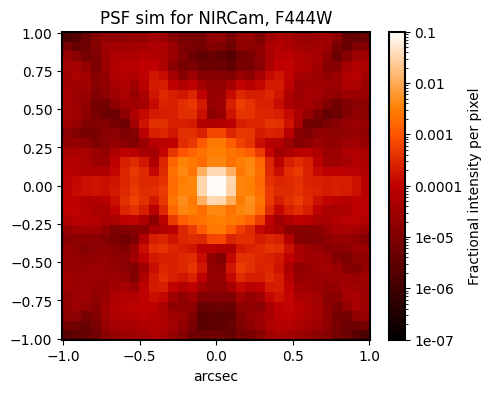

In [36]:
nc.filter='F444W'
psf444 = nc.calc_psf(fov_arcsec=2)
stpsf.display_psf(psf444, ext=3)

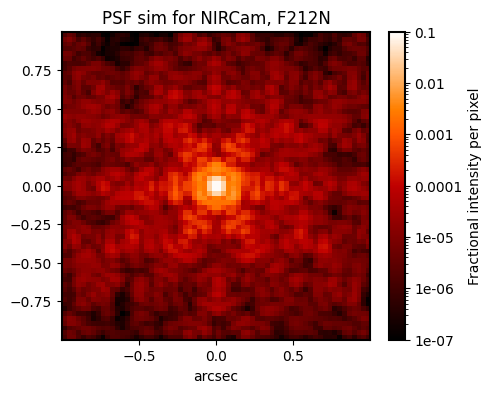

In [47]:
nc.filter='F212N'
psf212 = nc.calc_psf(fov_arcsec=2)
stpsf.display_psf(psf212, ext=3)

When possible, stpsf tries to automatically make sensible choices for other parameters. For example, switching the NIRCam filter to a long-wave or short-wave filter will automatically configure the detector and change the pixel scale to an appropriate value for that filter. 

We can also specify different locations within an instrument. This will generally result in small but measurable differences in PSFs. For information on the field dependence models, see the [JWST](https://stpsf.readthedocs.io/en/latest/jwst.html) and [Roman](https://stpsf.readthedocs.io/en/latest/roman.html) model details pages. 

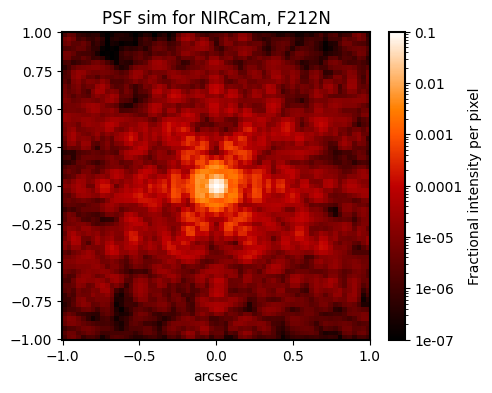

In [48]:
nc.detector='NRCB3'

nc.detector_position = (500, 1600)

psf212_nrcb3 = nc.calc_psf(fov_arcsec=2)
stpsf.display_psf(psf212_nrcb3, ext=3)

## A coronagraphic example

More complicated instrumental configurations are available by setting the instrument’s attributes. For instance, one can create an instance of MIRI and configure it for coronagraphic observations, as follows. This also shows off the ability to display the intermediate optical planes during a calculation:

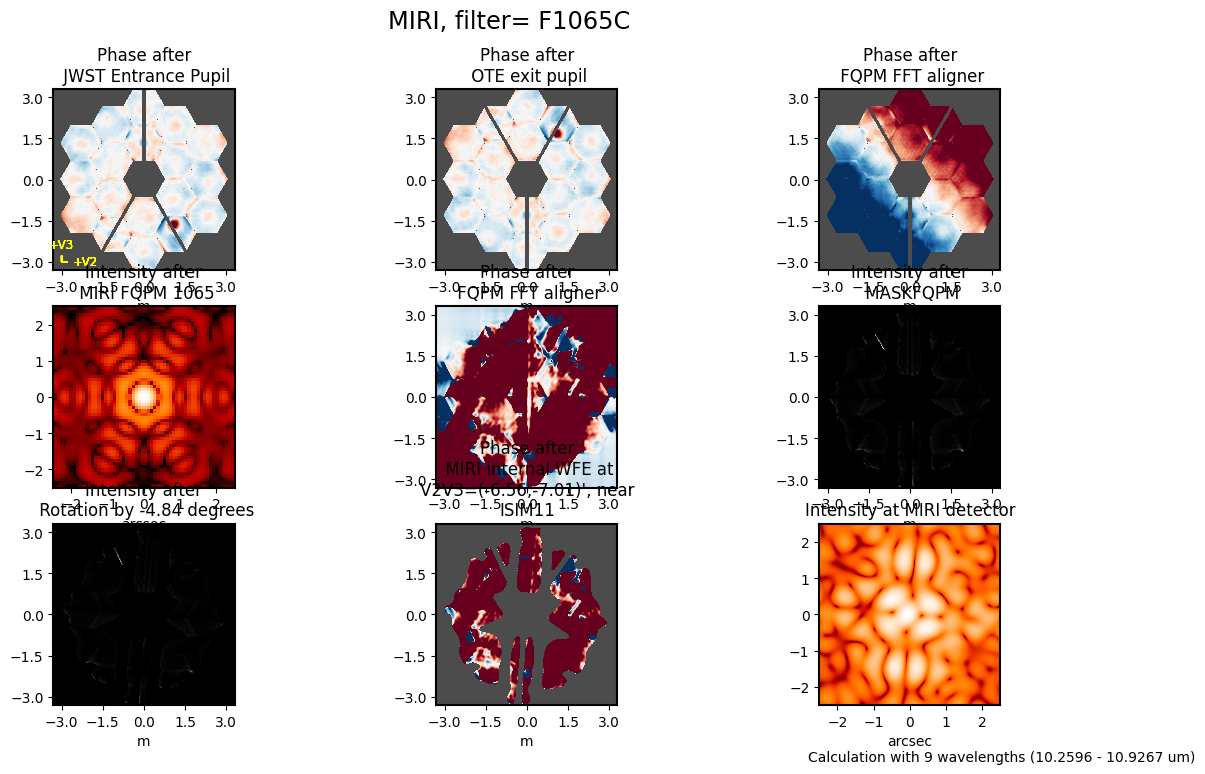

In [50]:
# optional: make the plot bigger so we can see everything more easily
matplotlib.pyplot.figure(figsize=(14, 8))

miri = stpsf.MIRI()
miri.filter = 'F1065C'
miri.image_mask = 'FQPM1065'
miri.pupil_mask = 'MASKFQPM'
miri_coron = miri.calc_psf(display=True)

##  More Examples

Here are some other example calculations taken from elsewhere in the ``stpsf`` documentation. 

Some of these differ cosmetically from the code there: this notebook contains some extra function calls to set an aesthetically pleasing size for each plot, and to save the outputs to PNGs. These lines are left out of the example docs HTML page just to streamline it a bit.

In [16]:
# Iterate over all instruments, calculating one example PSF for each
insts = ['NIRCam','NIRCam','NIRSpec','NIRISS', 'MIRI', 'FGS']
filts = ['F210M', 'F444W', 'F110W', 'F380M', 'F1000W', 'FGS']

psfs = {}
for i, (instname, filt) in enumerate(zip(insts, filts)):
    inst = stpsf.instrument(instname)
    inst.filter = filt
    psf = inst.calc_psf(fov_arcsec=5.0)
    psfs[instname+filt] = psf
    print(inst)

<JWST: NIRCam>
<JWST: NIRCam>
<JWST: NIRSpec>
<JWST: NIRISS>
<JWST: MIRI>
<JWST: FGS>


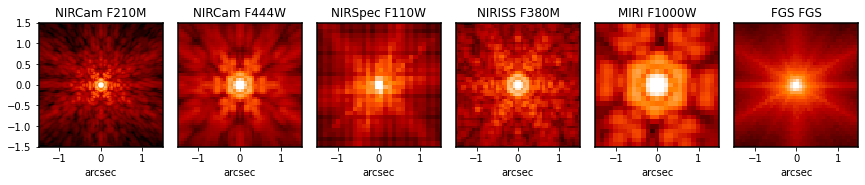

In [22]:
# Now make a nice plot of them
plt.figure(figsize=(16*0.75,3*0.75))
plt.subplots_adjust(wspace=0.05, bottom=0.05, top=0.9)
for i, (instname, filt) in enumerate(zip(insts, filts)):
    ax = plt.subplot(1,6,1+i)
    stpsf.display_psf(psfs[instname+filt], colorbar=False, title=instname+" "+filt, vmax=0.03, imagecrop=3, ext=1)
    if i > 0:
        ax.yaxis.set_visible(False)
plt.tight_layout()
plt.savefig('fig_instrument_comparison.png', dpi=150)

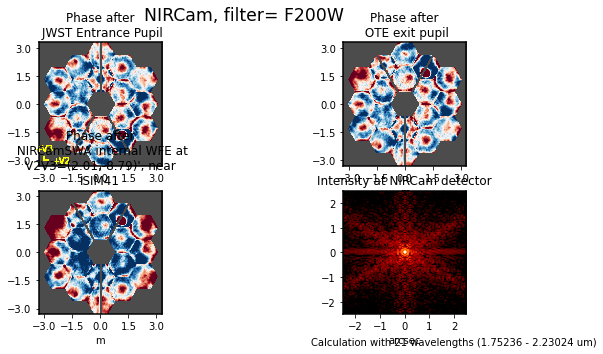

In [20]:
# Example plot of F200W calculation
plt.figure(figsize=(10,5))
nc = stpsf.NIRCam()
nc.filter =  'F200W'
nc.calc_psf(display=True)    
plt.savefig('fig1_nircam_f200w.png', dpi=120)

## Displaying a PSF as an image and as an encircled energy plot


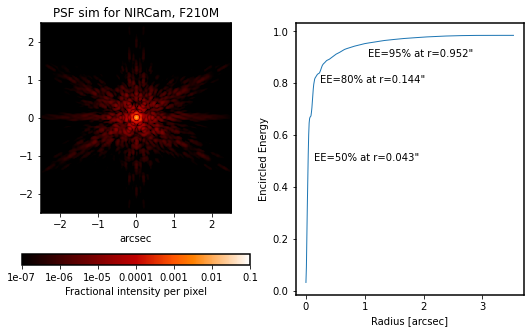

In [25]:
#create a NIRCam instance and calculate a PSF for F210M
nircam = stpsf.NIRCam()
nircam.filter = 'F210M'
psf210 = nircam.calc_psf()

# display the PSF and plot the encircled energy
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
stpsf.display_psf(psf210, colorbar_orientation='horizontal')
axis2 = plt.subplot(1,2,2)
stpsf.display_ee(psf210, ax=axis2)

psf210.writeto('nircam_F210M.fits', overwrite=True)
plt.savefig('fig_example_plot_nircam_f210m.png')

## Logging and More Verbose Output

STPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [26]:
stpsf.setup_logging()

STPSF log messages of level INFO and above will be shown.
STPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

In [27]:
stpsf.setup_logging(filename='my_log.txt')

STPSF log messages of level INFO and above will be shown.
STPSF log outputs will be directed to the screen.
STPSF log outputs will also be saved to file my_log.txt


In [28]:
psf = nc.calc_psf(nlambda=5, fov_arcsec=2)

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F200W...
[  poppy] PSF calc using fov_arcsec = 2.000000, oversample = 4, number of wavelengths = 5
[stpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: JWST+NIRCam
[  poppy] JWST Entrance Pupil: Loaded amplitude transmission from /Users/mperrin/software/stpsf-data/jwst_pupil_RevW_npix1024.fits.gz
[  poppy] JWST Entrance Pupil: Loaded OPD from /Users/mperrin/software/stpsf-data/JWST_OTE_OPD_cycle1_example_2022-07-30.fits
[stpsf] Loading field dependent model parameters from /Users/mperrin/software/stpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
[stpsf] Calculating field-dependent OTE OPD at v2 = 2.009 arcmin, v3 = -8.795 arcmin
[  poppy] Added pupil plane: JWST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] Added pupil plane: NIRCamSWA internal WFE at V2V3=(2.01,-8.79)', near IS

As you can see, the log output can be fairly verbose. This is often helpful in terms of understanding what's going on. 

If you no longer want this level of verbosity, you can turn off display of informational messages:

In [29]:
stpsf.setup_logging('ERROR')

STPSF log messages of level ERROR and above will be shown.
STPSF log outputs will be directed to the screen.
